In [35]:
# adapted from https://pyro.ai/examples/prodlda.html
# imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import torch
import time

import math
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange

# Importing modules
import re

#plotting libraries!
import matplotlib.pyplot as plt
%matplotlib inline

# Import the wordcloud library
from wordcloud import WordCloud

**Apply to movie set**  
**end goal:**  
want to  map/group movies (doc id) to topics so we can look up a topic and find related movies or vice versa  
**what we have:**  
movie descriptions for ~9k movies from netflix titles database  
**conversion:**  
- our LDA model takes in a matrix of token counts and outputs beta values
- need to convert what we have into a matrix of token counts using the CountVectorizer function
    - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [50]:
# import data and create relevant dfs
netflix_df = pd.read_csv("./netflix_titles.csv")
# df = pd.read_csv("./titles_sample.csv")
netflix_df['description'] = netflix_df['description'].map(lambda x: re.sub("([^\x00-\x7F])+","", x)) # from jessica's code
data = netflix_df['description'].to_numpy() 

# `max_df` removes common words - words with frequency higher than this across all documents
# `min_df` removes rare words - words that appear in less than min_df number of docs
# note: if min_df is too big, will get error in word cloud (i think because not enough data for all topics)
# max min_df i've found that works is 5
vectorizer = CountVectorizer(min_df=5, max_df=0.7, stop_words='english') # 1, 0.7
# docs is a binary matrix of size M x N where M is number of movies, N is number of words in vocab
# docs[i, j] is 1 if movie i's descriptoin has word j and 0 otherwise
docs = torch.from_numpy(vectorizer.fit_transform(data).toarray())

# creates df with words and indices corresponding to words 
# used to convert betas back to words in word cloud plots
vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names()
vocab['index'] = vocab.index

print('Dictionary size: %d' % len(vocab))
print('Corpus size: {}'.format(docs.shape))

Dictionary size: 4663
Corpus size: torch.Size([8807, 4663])


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [52]:
netflix_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [38]:
# setting global variables related to LDA computation
smoke_test=False
seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_topics = 15 if not smoke_test else 3
docs = docs.float().to(device)
batch_size = 32
learning_rate = 1e-3
num_epochs = 50 if not smoke_test else 1

In [39]:
class Encoder(nn.Module):
    # Base class for the encoder net, used in the guide
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        self.fc1 = nn.Linear(vocab_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)
        # NB: here we set `affine=False` to reduce the number of learning parameters
        # See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # for the effect of this flag in BatchNorm1d
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse

    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = (0.5 * logtheta_logvar).exp()  # Enforces positivity
        return logtheta_loc, logtheta_scale


class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return F.softmax(self.bn(self.beta(inputs)), dim=1)


class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout)
        self.decoder = Decoder(vocab_size, num_topics, dropout)

    def model(self, docs):
        pyro.module("decoder", self.decoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics))
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            theta = F.softmax(logtheta, -1)

            # conditional distribution of 𝑤𝑛 is defined as
            # 𝑤𝑛|𝛽,𝜃 ~ Categorical(𝜎(𝛽𝜃))
            count_param = self.decoder(theta)
            # Currently, PyTorch Multinomial requires `total_count` to be homogeneous.
            # Because the numbers of words across documents can vary,
            # we will use the maximum count accross documents here.
            # This does not affect the result because Multinomial.log_prob does
            # not require `total_count` to evaluate the log probability.
            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs',
                dist.Multinomial(total_count, count_param),
                obs=docs
            )

    def guide(self, docs):
        pyro.module("encoder", self.encoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            logtheta_loc, logtheta_scale = self.encoder(docs)
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))

    def beta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        return self.decoder.beta.weight.cpu().detach().T

In [40]:
# training 
pyro.clear_param_store()

prodLDA = ProdLDA(
    vocab_size=docs.shape[1],
    num_topics=num_topics,
    hidden=100 if not smoke_test else 10,
    dropout=0.2
)
prodLDA.to(device)

optimizer = pyro.optim.Adam({"lr": learning_rate})
svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss=TraceMeanField_ELBO())
num_batches = int(math.ceil(docs.shape[0] / batch_size)) if not smoke_test else 1

start = time.perf_counter()
bar = trange(num_epochs)
for epoch in bar:
    running_loss = 0.0
    for i in range(num_batches):
        batch_docs = docs[i * batch_size:(i + 1) * batch_size, :]
        loss = svi.step(batch_docs)
        running_loss += loss / batch_docs.size(0)

    bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss))
end = time.perf_counter()
print(f"Finished in {(end - start)/60:0.4f} minutes")

100%|██████████| 50/50 [01:50<00:00,  2.21s/it, epoch_loss=2.07e+04]

Finished in 1.8385 minutes


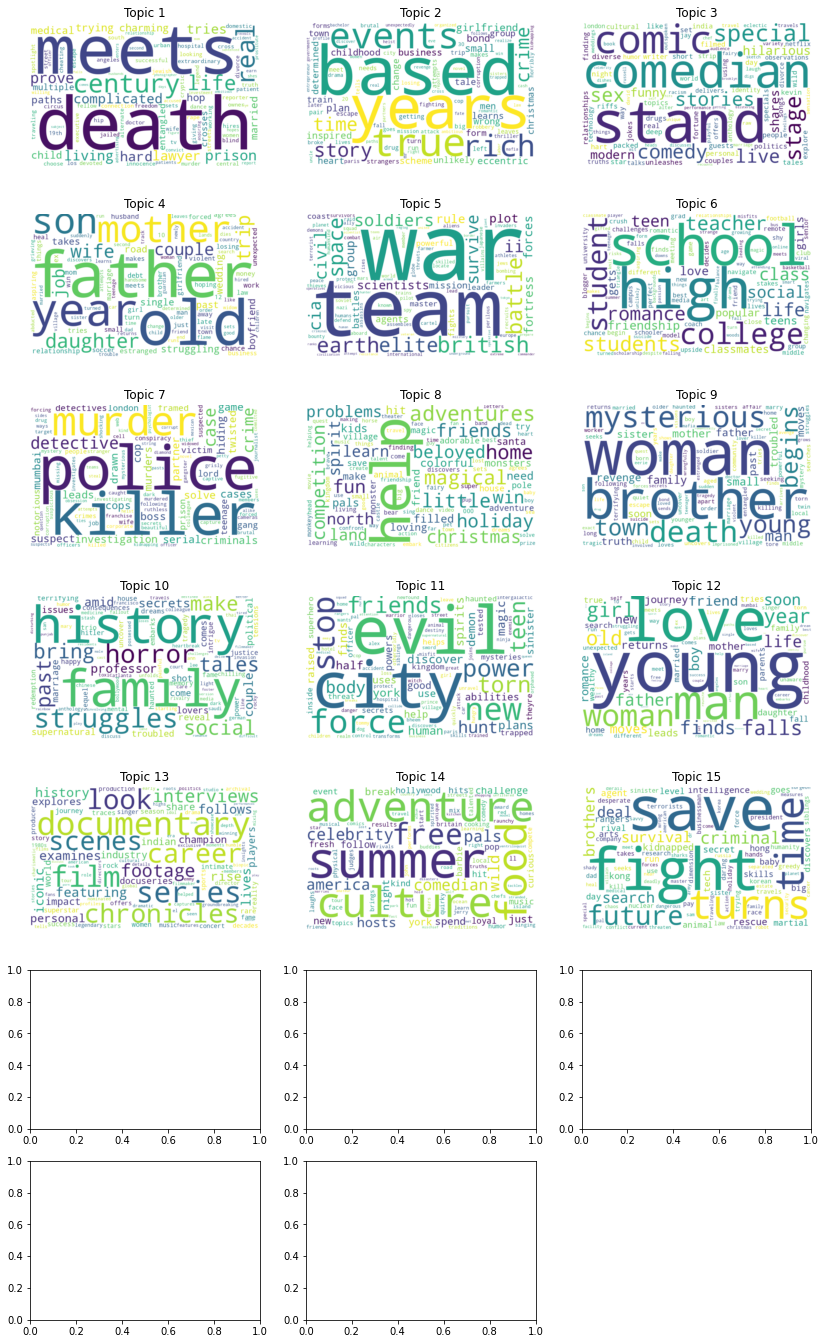

In [41]:
def plot_word_cloud(b, ax, v, n):
    sorted_, indices = torch.sort(b, descending=True) # sorts betas by descending order
    df = pd.DataFrame(indices[:100].numpy(), columns=['index'])
    words = pd.merge(df, v[['index', 'word']],
                     how='left', on='index')['word'].values.tolist()
    sizes = (sorted_[:100] * 1000).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")

beta = prodLDA.beta()
fig, axs = plt.subplots(7, 3, figsize=(14, 24))
for n in range(beta.shape[0]):
    i, j = divmod(n, 3)
    plot_word_cloud(beta[n], axs[i, j], vocab, n)
axs[-1, -1].axis('off');

plt.show()

**adding topic number and probability of being in topic to netflix db**
- for each movie, need to find largest topic probability based on words in docs corpus array

In [71]:
# betas is a TxW array where T is number of topics, W is number of words
# betas[i, j] gives probability that word j is in topic i
betas = prodLDA.beta()
# for each movie, find maximum of beta values to assign topic
topics = []
topic_probs = []
num_movies = len(netflix_df)
for i in range(num_movies):
    words_tensor = docs[i]
    word_indices = ((words_tensor==1).nonzero(as_tuple=True)[0]) # get indices of words used in movie netflix_df[i]
    max_probability = 0
    topic = None
    for word_index in word_indices: # find max topic prob given words in movie i from betas object
        max_word_probability = max(betas[:,word_index]).numpy()
        if max_word_probability > max_probability:
            max_probability = max_word_probability
            topic = torch.argmax(betas[:,word_index]).numpy()+1
    topics.append(topic)
    topic_probs.append(max_probability)
netflix_df['Topic'] = topics
netflix_df['Probability'] = topic_probs
netflix_df['Doc'] = range(num_movies)
netflix_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,Topic,Probability,Doc
0,s1,Movie,dick johnson is dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",8,0.5059975,0
1,s2,TV Show,blood & water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",6,0.6462104,1
2,s3,TV Show,ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,5,0.6899267,2
3,s4,TV Show,jailbirds new orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",13,0.62366635,3
4,s5,TV Show,kota factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,6,0.46665427,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",7,0.6370697,8802
8803,s8804,TV Show,zombie dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",12,0.42056867,8803
8804,s8805,Movie,zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,6,0.532185,8804
8805,s8806,Movie,zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",5,0.41032356,8805


In [72]:
def recommend_by_storyline(title, df):
    recommended = []
    top10_list = []
    
    title = title.lower()
    df['title'] = df['title'].str.lower()
    topic_num = df[df['title']==title].Topic.values
    doc_num = df[df['title']==title].Doc.values    
    
    output_df = df[df['Topic']==topic_num[0]].sort_values('Probability', ascending=False).reset_index(drop=True)

    index = output_df[output_df['Doc']==doc_num[0]].index[0]
    
    # return the 10 results with closest probability of belonging to topic `topic_num`
    top10_list += list(output_df.iloc[index-5:index].index)
    top10_list += list(output_df.iloc[index+1:index+6].index)
    
    output_df['title'] = output_df['title'].str.title()
    for each in top10_list:
        recommended.append(output_df.iloc[each].title)
        
    return recommended

In [73]:
recommend_by_storyline("Avengers: Infinity War", netflix_df)

['Monster House',
 'Warehoused',
 'Check The Store Next Door: The Next Chapter',
 'Major Dad',
 'Tope: The Bait',
 'Nocturnal Animals',
 'Juman',
 'Teen Mom 2',
 'Benji: Off The Leash',
 'Tango Feroz']